In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Sima

/content/drive/MyDrive/Sima


/content/drive/MyDrive/Sima

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('temp_data.csv')  # Load data

#  Cleaning
data = data.drop('State', axis=1)
data.loc[data['Day'] == 0, 'Month'] = 2
data.loc[data['Day'] == 0, 'Day'] = 29
data.loc[(data['City'] == 'Munich') & (data['Day'] == 30) & (data['Month'] == 12) & (data['Year'] == 2015) & (data['AvgTemperature'] == -99.0), 'Day'] = 31

In [ ]:
def find_missing_dates(df):
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

    missing_dates = {}
    for city, group in df.groupby('City'):
        full_range = pd.date_range(start=group['Date'].min(), end=group['Date'].max(), freq='D')
        missing = full_range.difference(group['Date'])
        if not missing.empty:
            missing_dates[city] = missing

    return missing_dates

def check_data_completeness(df):
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

    results = {}
    for city, group in df.groupby('City'):
        full_range = pd.date_range(start=group['Date'].min(), end=group['Date'].max(), freq='D')
        is_complete = np.array_equal(group['Date'].sort_values().unique(), full_range)
        results[city] = is_complete

    return results

In [ ]:
missing_dates = find_missing_dates(data)
missing_dates

{'Banjul': DatetimeIndex(['2008-01-01', '2008-01-02', '2008-01-03', '2008-01-04',
                '2008-01-05', '2008-01-06', '2008-01-07', '2008-01-08',
                '2008-01-09', '2008-01-10',
                ...
                '2009-12-22', '2009-12-23', '2009-12-24', '2009-12-25',
                '2009-12-26', '2009-12-27', '2009-12-28', '2009-12-29',
                '2009-12-30', '2009-12-31'],
               dtype='datetime64[ns]', length=731, freq=None),
 'Lilongwe': DatetimeIndex(['2007-01-01', '2007-01-02', '2007-01-03', '2007-01-04',
                '2007-01-05', '2007-01-06', '2007-01-07', '2007-01-08',
                '2007-01-09', '2007-01-10',
                ...
                '2009-12-22', '2009-12-23', '2009-12-24', '2009-12-25',
                '2009-12-26', '2009-12-27', '2009-12-28', '2009-12-29',
                '2009-12-30', '2009-12-31'],
               dtype='datetime64[ns]', length=1096, freq=None),
 'Nairobi': DatetimeIndex(['2007-01-01', '2007-01-02', '2

In [ ]:
data = data[~data['City'].isin(missing_dates.keys())]
all(check_data_completeness(data))

True

In [ ]:
data = data[data['AvgTemperature'] > -99.0]

## Daily Preprocess

In [ ]:
index = 76
cities = data['City'].unique().tolist()
cities.sort()
city = cities[index]
city_data = data[data['City'] == city].reset_index()
print("We are selecting \"" + city + "\" city for training with \"" + str(len(city_data)) + "\" data points.")

We are selecting "Moscow" city for training with "9235" data points.


In [ ]:
# Convert date information to a datetime object and set it as the index
city_data['Date'] = pd.to_datetime(city_data[['Year', 'Month', 'Day']])
city_data.set_index('Date', inplace=True)
city_data.sort_index(inplace=True)

# Select only the AvgTemperature column for simplicity, or multiple columns if needed
time_series = city_data['AvgTemperature']

In [ ]:
# Calculate indices for 70% train, 20% validation, 10% test splits
train_size = int(len(time_series) * 0.7)
remaining = len(time_series) - train_size
validation_size = int(remaining * 0.67)  # Approximately 20% of the total
test_size = remaining - validation_size  # Approximately 10% of the total

# Generate train, validation, and test sets
train_data = time_series.iloc[:train_size]
remaining_data = time_series.iloc[train_size:]

# Randomly sample validation and test sets from the remaining data
validation_data = remaining_data.sample(n=validation_size)
test_data = remaining_data.drop(validation_data.index)  # Drop validation data points from remaining to form test set

In [ ]:
# Create a scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform all sets
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
validation_scaled = scaler.transform(validation_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

In [ ]:
def create_sequences(data, sequence_length=30):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        xs.append(data[i:(i + sequence_length)])
        ys.append(data[i + sequence_length])
    return np.array(xs), np.array(ys)

# Example usage
sequence_length = 15  # Using 30 days of data to predict the next day
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val, y_val = create_sequences(validation_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

In [ ]:
# Create the LSTM model
# Determine the number of features in your input and output
n_features_in = X_train.shape[2]  # number of features in the input
n_features_out = y_train.shape[1]  # number of features in the output

model = Sequential()

# Add LSTM layers with return_sequences=True since we need the full sequence output
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True, input_shape=(None, n_features_in))))
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(8, activation='relu')))
model.add(TimeDistributed(Dense(n_features_out)))

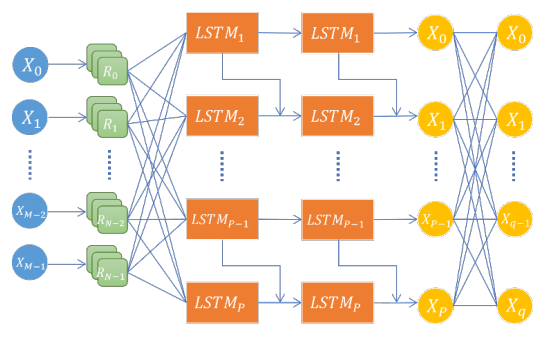

In [ ]:
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

In [ ]:
# Define the optimizer with a specific learning rate
learning_rate = 0.0001  # Example learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=RootMeanSquaredError())

# Setup early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),
                    callbacks=[early_stopping], batch_size=32, verbose=1)

Epoch 1/30
202/202 [==============================] - 3s 9ms/step - loss: 0.1053 - root_mean_squared_error: 0.3244 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1775
Epoch 2/30
202/202 [==============================] - 1s 7ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1748
Epoch 3/30
202/202 [==============================] - 1s 7ms/step - loss: 0.0050 - root_mean_squared_error: 0.0706 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1756
Epoch 4/30
202/202 [==============================] - 2s 8ms/step - loss: 0.0048 - root_mean_squared_error: 0.0695 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1763
Epoch 5/30
202/202 [==============================] - 2s 11ms/step - loss: 0.0047 - root_mean_squared_error: 0.0687 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1767
Epoch 6/30
202/202 [==============================] - 2s 9ms/step - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0313 - val

## Results 7 Days

18/18 [==============================] - 0s 2ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850
Test Loss: [0.007226441986858845, 0.08500847965478897]


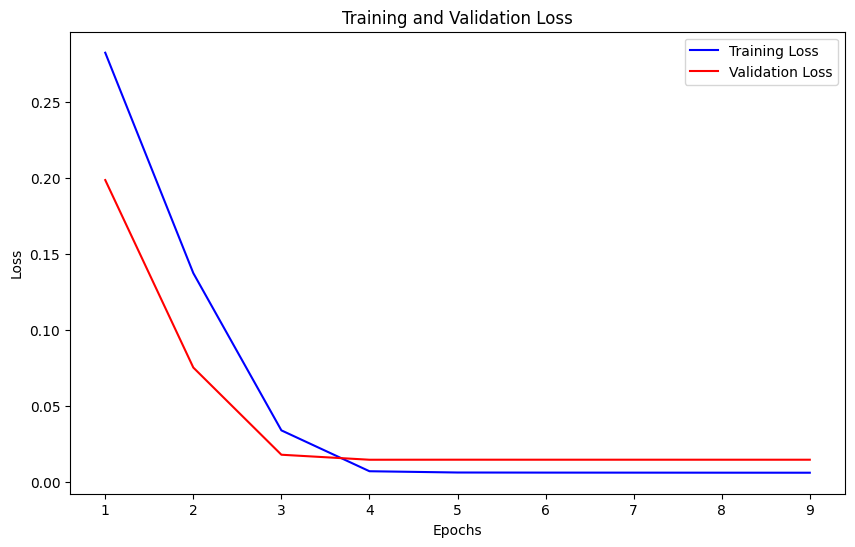

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', test_loss)

# Extract history for plotting loss over epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

36/36 [==============================] - 1s 3ms/step


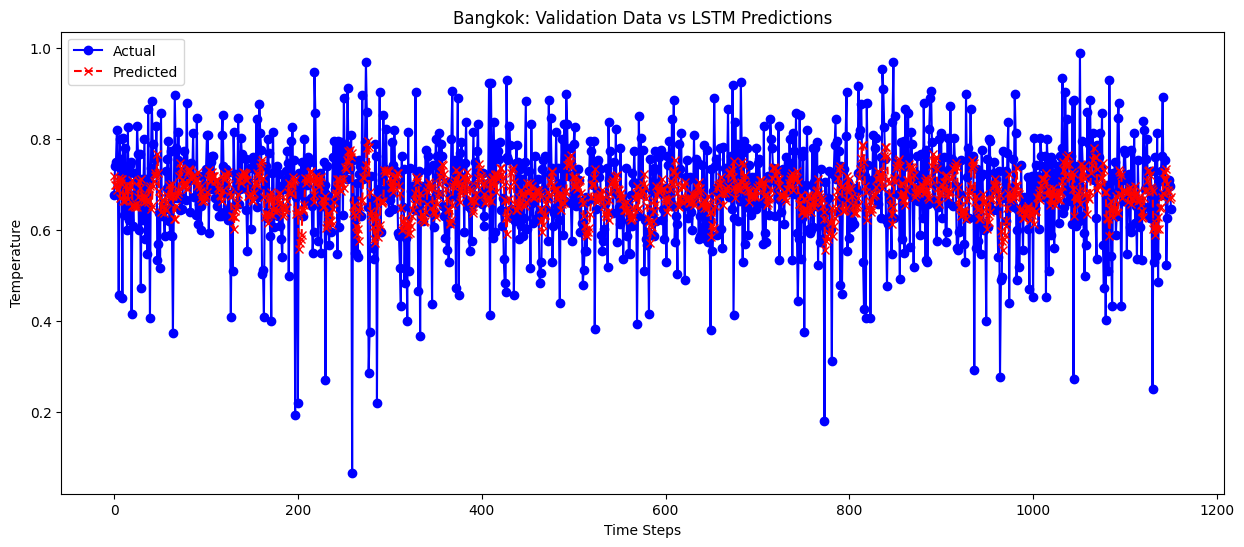

In [ ]:
# Make predictions on the validation data
y_val_pred = model.predict(X_val)

# Reshape y_val if necessary to ensure it matches the predictions shape
y_val = y_val.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_val, label='Actual', color='blue', marker='o')
plt.plot(y_val_pred.flatten(), label='Predicted', color='red', linestyle='--', marker='x')
plt.title(f"{city}: Validation Data vs LSTM Predictions")
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

## Results 15 Days

18/18 [==============================] - 1s 4ms/step - loss: 0.0079 - root_mean_squared_error: 0.0892
Test Loss: [0.007949293591082096, 0.0891588106751442]


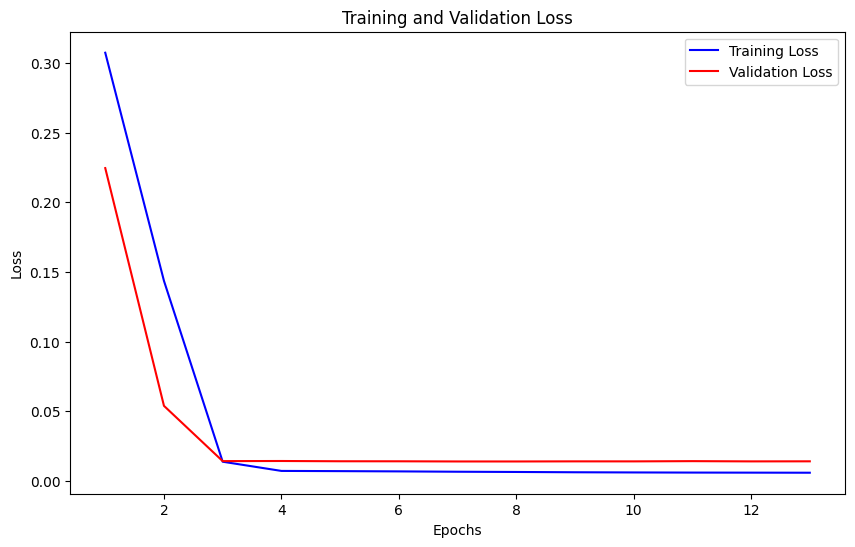

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', test_loss)

# Extract history for plotting loss over epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

36/36 [==============================] - 0s 4ms/step


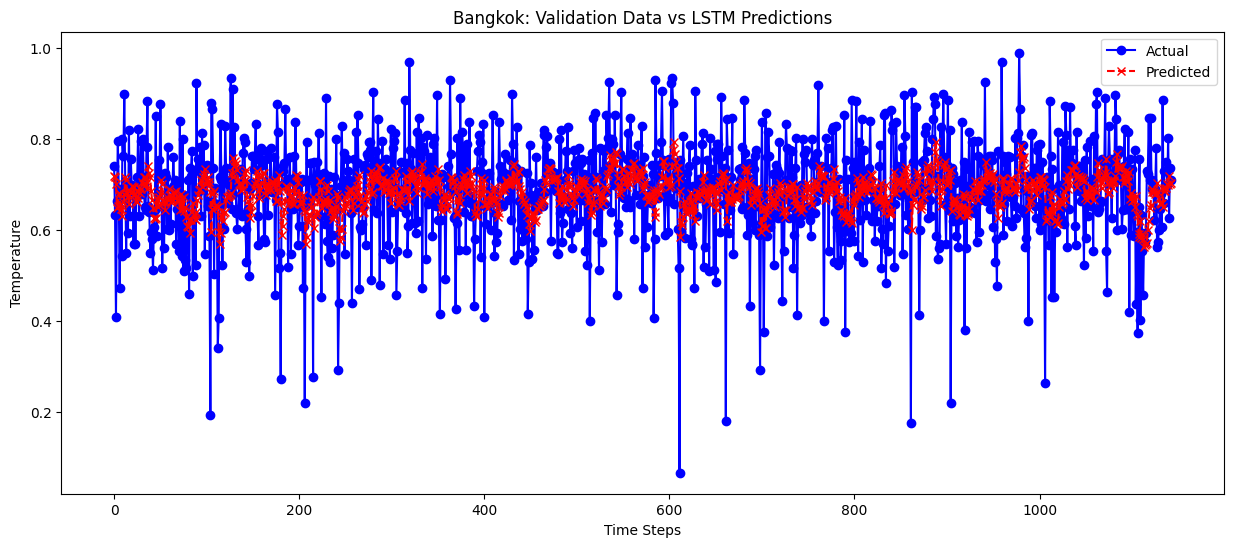

In [ ]:
# Make predictions on the validation data
y_val_pred = model.predict(X_val)

# Reshape y_val if necessary to ensure it matches the predictions shape
y_val = y_val.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_val, label='Actual', color='blue', marker='o')
plt.plot(y_val_pred.flatten(), label='Predicted', color='red', linestyle='--', marker='x')
plt.title(f"{city}: Validation Data vs LSTM Predictions")
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

36/36 [==============================] - 1s 31ms/step


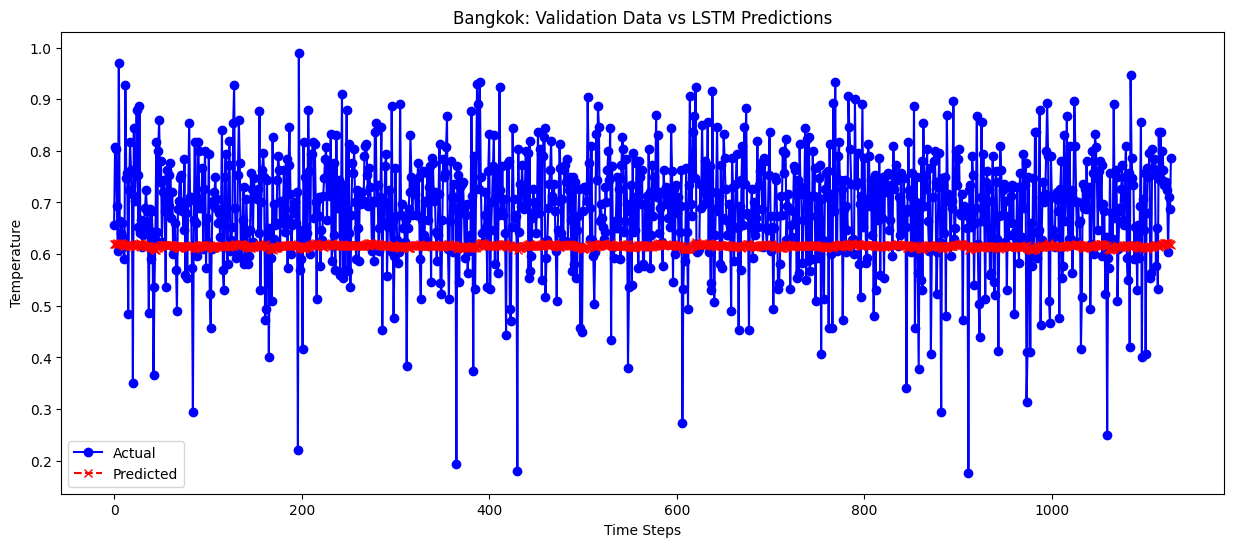

In [ ]:
# SGD
# Make predictions on the validation data
y_val_pred = model.predict(X_val)

# Reshape y_val if necessary to ensure it matches the predictions shape
y_val = y_val.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_val, label='Actual', color='blue', marker='o')
plt.plot(y_val_pred.flatten(), label='Predicted', color='red', linestyle='--', marker='x')
plt.title(f"{city}: Validation Data vs LSTM Predictions")
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

## Results 15 Days

29/29 [==============================] - 0s 3ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867
Test Loss: [0.007525481283664703, 0.08674953132867813]


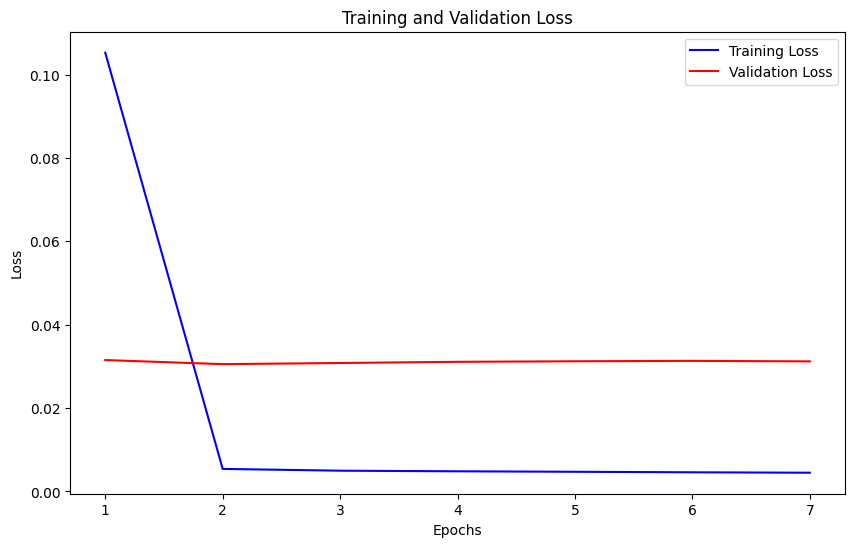

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', test_loss)

# Extract history for plotting loss over epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

58/58 [==============================] - 0s 5ms/step


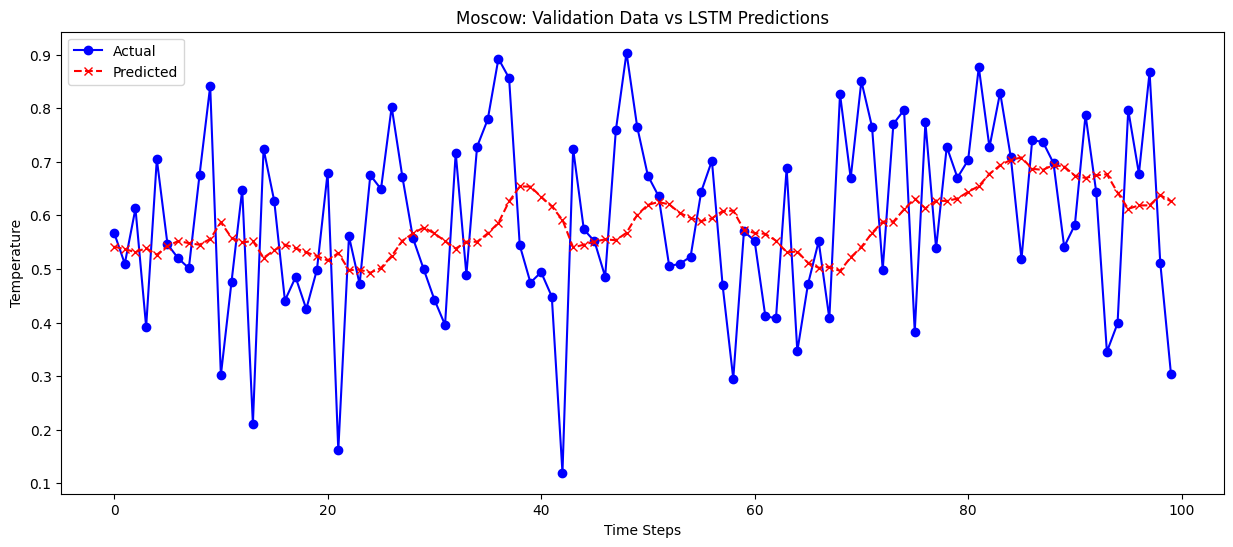

In [ ]:
# Make predictions on the validation data
y_val_pred = model.predict(X_val)

# Reshape y_val if necessary to ensure it matches the predictions shape
y_val = y_val.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_val[:100], label='Actual', color='blue', marker='o')
plt.plot(y_val_pred.flatten()[:100], label='Predicted', color='red', linestyle='--', marker='x')
plt.title(f"{city}: Validation Data vs LSTM Predictions")
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

36/36 [==============================] - 1s 31ms/step


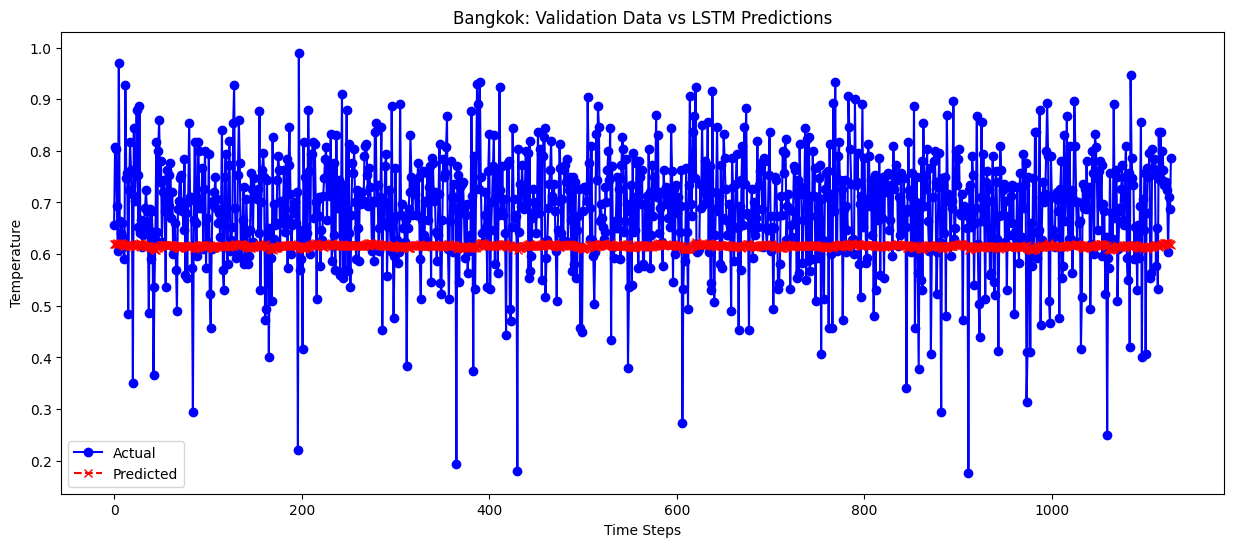

In [ ]:
# SGD
# Make predictions on the validation data
y_val_pred = model.predict(X_val)

# Reshape y_val if necessary to ensure it matches the predictions shape
y_val = y_val.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_val, label='Actual', color='blue', marker='o')
plt.plot(y_val_pred.flatten(), label='Predicted', color='red', linestyle='--', marker='x')
plt.title(f"{city}: Validation Data vs LSTM Predictions")
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

## Results 30 Days

17/17 [==============================] - 0s 4ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949
Test Loss: [0.00900015328079462, 0.09486913681030273]


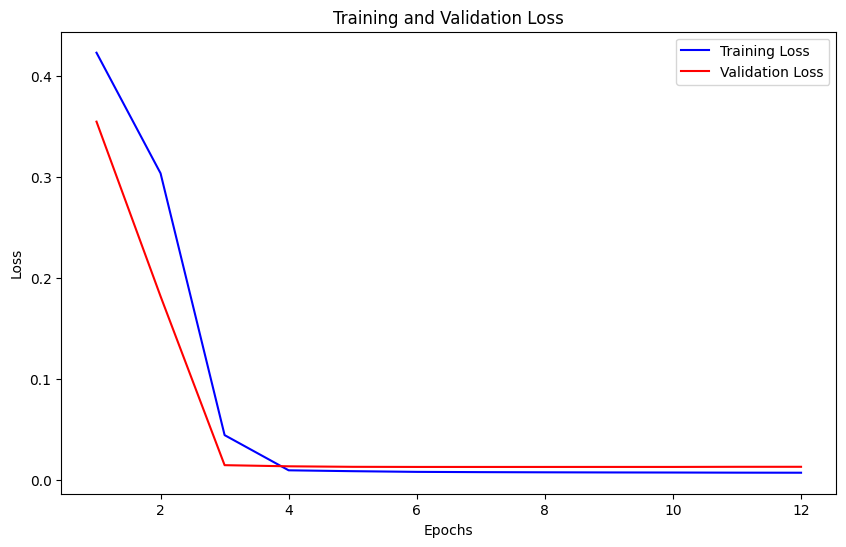

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', test_loss)

# Extract history for plotting loss over epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

36/36 [==============================] - 0s 4ms/step


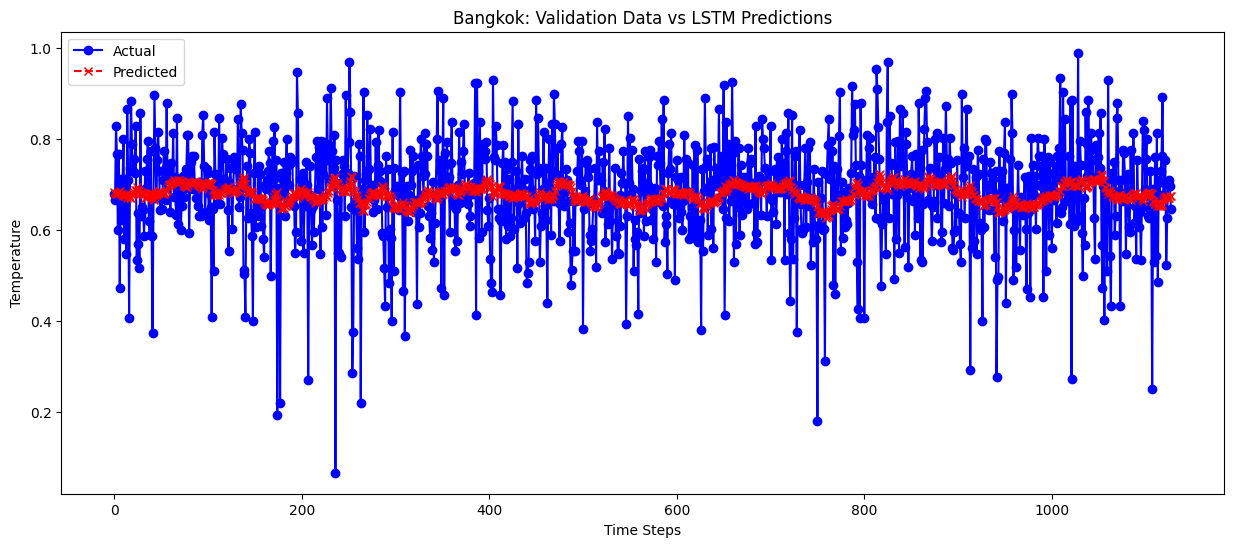

In [ ]:
# Make predictions on the validation data
y_val_pred = model.predict(X_val)

# Reshape y_val if necessary to ensure it matches the predictions shape
y_val = y_val.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_val, label='Actual', color='blue', marker='o')
plt.plot(y_val_pred.flatten(), label='Predicted', color='red', linestyle='--', marker='x')
plt.title(f"{city}: Validation Data vs LSTM Predictions")
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Bangkok

## Monthly Preprocess

In [ ]:
index = 10
cities = data['City'].unique().tolist()
cities.sort()
city = cities[index]
city_data = data[data['City'] == city].reset_index()
print("We are selecting \"" + city + "\" city for training with \"" + str(len(city_data)) + "\" data points.")

We are selecting "Bangkok" city for training with "5763" data points.


In [ ]:
# Convert date information to a datetime object and set it as the index
city_data['Date'] = pd.to_datetime(city_data[['Year', 'Month', 'Day']])
city_data.set_index('Date', inplace=True)
city_data.sort_index(inplace=True)

# Select only the AvgTemperature column for simplicity, or multiple columns if needed
time_series = city_data['AvgTemperature'].resample('M').mean()

In [ ]:
# Calculate indices for 70% train, 20% validation, 10% test splits
train_size = int(len(time_series) * 0.7)
remaining = len(time_series) - train_size
validation_size = int(remaining * 0.67)  # Approximately 20% of the total
test_size = remaining - validation_size  # Approximately 10% of the total

# Generate train, validation, and test sets
train_data = time_series.iloc[:train_size]
remaining_data = time_series.iloc[train_size:]

# Randomly sample validation and test sets from the remaining data
validation_data = remaining_data.sample(n=validation_size)
test_data = remaining_data.drop(validation_data.index)  # Drop validation data points from remaining to form test set

In [ ]:
# Create a scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform all sets
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
validation_scaled = scaler.transform(validation_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

In [ ]:
def create_sequences(data, sequence_length=30):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        xs.append(data[i:(i + sequence_length)])
        ys.append(data[i + sequence_length])
    return np.array(xs), np.array(ys)

# Example usage
sequence_length = 3  # Using 3 Months of data to predict the next day
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val, y_val = create_sequences(validation_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

In [ ]:
# Create the LSTM model
# Determine the number of features in your input and output
n_features_in = X_train.shape[2]  # number of features in the input
n_features_out = y_train.shape[1]  # number of features in the output

model = Sequential()

# Add LSTM layers with return_sequences=True since we need the full sequence output
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True, input_shape=(None, n_features_in))))
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(8, activation='relu')))
model.add(TimeDistributed(Dense(n_features_out)))

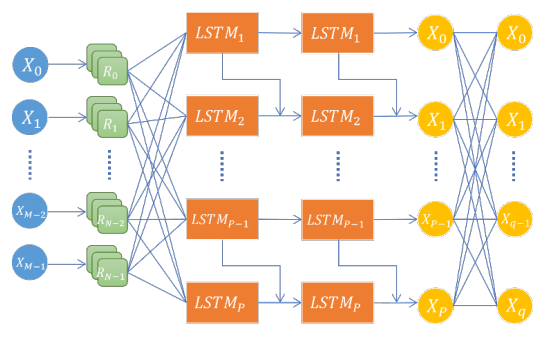

In [ ]:
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

In [ ]:
# Define the optimizer with a specific learning rate
learning_rate = 0.001  # Example learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=RootMeanSquaredError())

# Setup early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),
                    callbacks=[early_stopping], batch_size=32, verbose=1)

Epoch 1/30
5/5 [==============================] - 2s 73ms/step - loss: 0.5303 - root_mean_squared_error: 0.7282 - val_loss: 0.4463 - val_root_mean_squared_error: 0.6680
Epoch 2/30
5/5 [==============================] - 0s 10ms/step - loss: 0.4898 - root_mean_squared_error: 0.6999 - val_loss: 0.4122 - val_root_mean_squared_error: 0.6420
Epoch 3/30
5/5 [==============================] - 0s 17ms/step - loss: 0.4533 - root_mean_squared_error: 0.6732 - val_loss: 0.3813 - val_root_mean_squared_error: 0.6175
Epoch 4/30
5/5 [==============================] - 0s 11ms/step - loss: 0.4192 - root_mean_squared_error: 0.6474 - val_loss: 0.3518 - val_root_mean_squared_error: 0.5932
Epoch 5/30
5/5 [==============================] - 0s 12ms/step - loss: 0.3865 - root_mean_squared_error: 0.6217 - val_loss: 0.3224 - val_root_mean_squared_error: 0.5678
Epoch 6/30
5/5 [==============================] - 0s 11ms/step - loss: 0.3541 - root_mean_squared_error: 0.5950 - val_loss: 0.2927 - val_root_mean_squared_

## Results 3 Months

1/1 [==============================] - 1s 676ms/step - loss: 0.0162 - root_mean_squared_error: 0.1275
Test Loss: [0.016249051317572594, 0.12747175991535187]


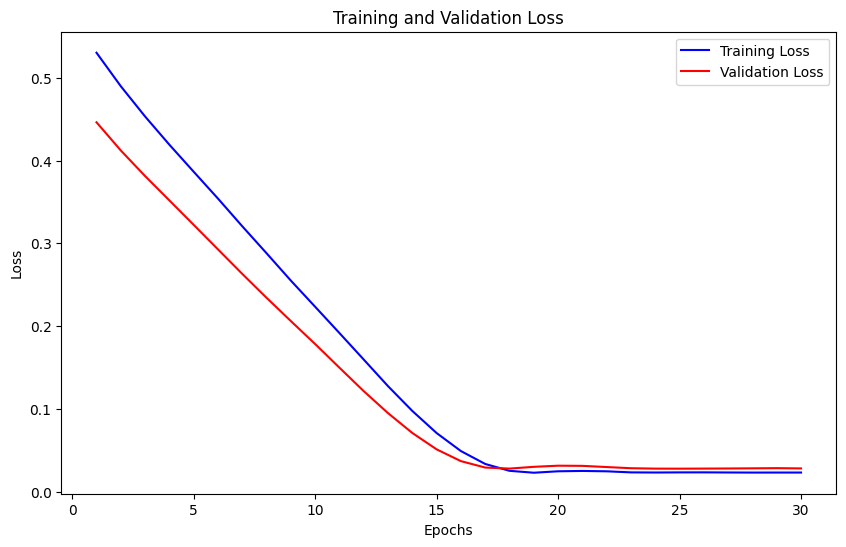

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', test_loss)

# Extract history for plotting loss over epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 10ms/step


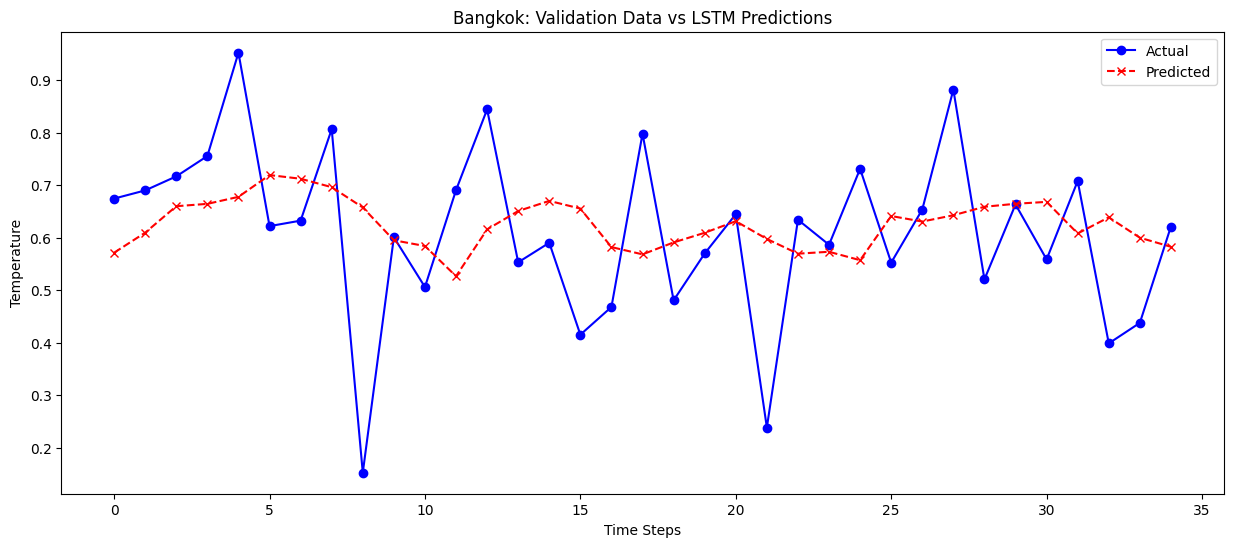

In [ ]:
# Make predictions on the validation data
y_val_pred = model.predict(X_val)

# Reshape y_val if necessary to ensure it matches the predictions shape
y_val = y_val.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_val, label='Actual', color='blue', marker='o')
plt.plot(y_val_pred.flatten(), label='Predicted', color='red', linestyle='--', marker='x')
plt.title(f"{city}: Validation Data vs LSTM Predictions")
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Amsterdam 3 Months

## Monthly Preprocess

In [ ]:
index = 5
cities = data['City'].unique().tolist()
cities.sort()
city = cities[index]
city_data = data[data['City'] == city].reset_index()
print("We are selecting \"" + city + "\" city for training with \"" + str(len(city_data)) + "\" data points.")

We are selecting "Amsterdam" city for training with "9236" data points.


In [ ]:
# Convert date information to a datetime object and set it as the index
city_data['Date'] = pd.to_datetime(city_data[['Year', 'Month', 'Day']])
city_data.set_index('Date', inplace=True)
city_data.sort_index(inplace=True)

# Select only the AvgTemperature column for simplicity, or multiple columns if needed
time_series = city_data['AvgTemperature'].resample('M').mean()

In [ ]:
# Calculate indices for 70% train, 20% validation, 10% test splits
train_size = int(len(time_series) * 0.7)
remaining = len(time_series) - train_size
validation_size = int(remaining * 0.67)  # Approximately 20% of the total
test_size = remaining - validation_size  # Approximately 10% of the total

# Generate train, validation, and test sets
train_data = time_series.iloc[:train_size]
remaining_data = time_series.iloc[train_size:]

# Randomly sample validation and test sets from the remaining data
validation_data = remaining_data.sample(n=validation_size)
test_data = remaining_data.drop(validation_data.index)  # Drop validation data points from remaining to form test set

In [ ]:
# Create a scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform all sets
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
validation_scaled = scaler.transform(validation_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

In [ ]:
def create_sequences(data, sequence_length=30):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        xs.append(data[i:(i + sequence_length)])
        ys.append(data[i + sequence_length])
    return np.array(xs), np.array(ys)

# Example usage
sequence_length = 3  # Using 3 Months of data to predict the next day
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val, y_val = create_sequences(validation_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

In [ ]:
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

In [ ]:
# Define the optimizer with a specific learning rate
learning_rate = 0.001  # Example learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=RootMeanSquaredError())

# Setup early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),
                    callbacks=[early_stopping], batch_size=32, verbose=1)

Epoch 1/30
7/7 [==============================] - 2s 49ms/step - loss: 0.3380 - root_mean_squared_error: 0.5814 - val_loss: 0.3156 - val_root_mean_squared_error: 0.5618
Epoch 2/30
7/7 [==============================] - 0s 8ms/step - loss: 0.3023 - root_mean_squared_error: 0.5498 - val_loss: 0.2841 - val_root_mean_squared_error: 0.5330
Epoch 3/30
7/7 [==============================] - 0s 10ms/step - loss: 0.2696 - root_mean_squared_error: 0.5192 - val_loss: 0.2549 - val_root_mean_squared_error: 0.5048
Epoch 4/30
7/7 [==============================] - 0s 8ms/step - loss: 0.2397 - root_mean_squared_error: 0.4896 - val_loss: 0.2266 - val_root_mean_squared_error: 0.4760
Epoch 5/30
7/7 [==============================] - 0s 8ms/step - loss: 0.2099 - root_mean_squared_error: 0.4582 - val_loss: 0.1984 - val_root_mean_squared_error: 0.4454
Epoch 6/30
7/7 [==============================] - 0s 7ms/step - loss: 0.1799 - root_mean_squared_error: 0.4242 - val_loss: 0.1696 - val_root_mean_squared_erro

## Results Months

1/1 [==============================] - 0s 27ms/step - loss: 0.0523 - root_mean_squared_error: 0.2287
Test Loss: [0.05230007320642471, 0.22869209945201874]


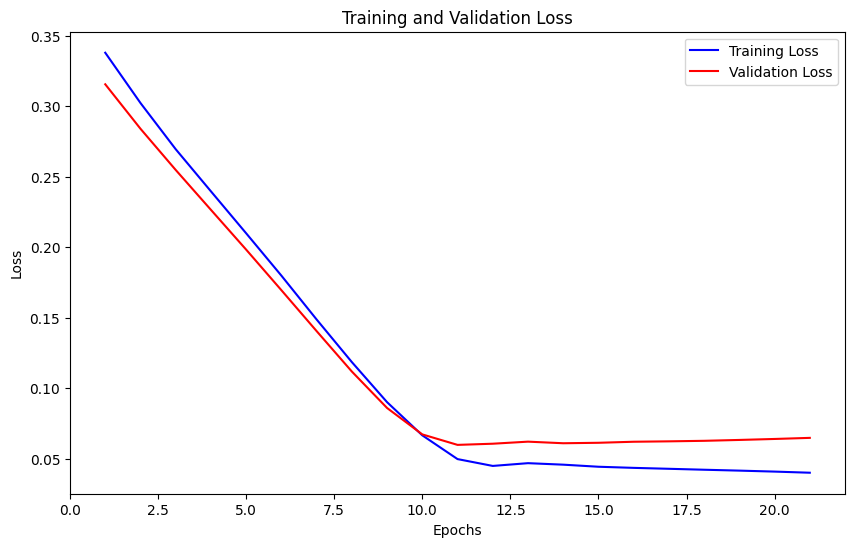

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', test_loss)

# Extract history for plotting loss over epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 6ms/step


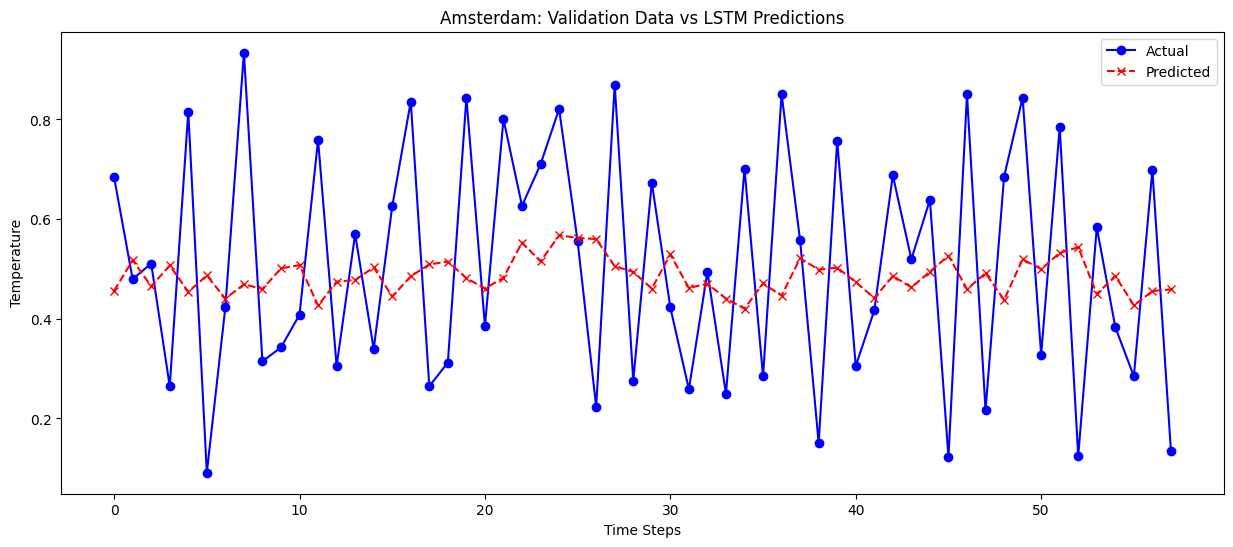

In [ ]:
# Make predictions on the validation data
y_val_pred = model.predict(X_val)

# Reshape y_val if necessary to ensure it matches the predictions shape
y_val = y_val.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_val, label='Actual', color='blue', marker='o')
plt.plot(y_val_pred.flatten(), label='Predicted', color='red', linestyle='--', marker='x')
plt.title(f"{city}: Validation Data vs LSTM Predictions")
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Amsterdam 6 Months

## Monthly Preprocess

In [ ]:
index = 5
cities = data['City'].unique().tolist()
cities.sort()
city = cities[index]
city_data = data[data['City'] == city].reset_index()
print("We are selecting \"" + city + "\" city for training with \"" + str(len(city_data)) + "\" data points.")

We are selecting "Amsterdam" city for training with "9236" data points.


In [ ]:
# Convert date information to a datetime object and set it as the index
city_data['Date'] = pd.to_datetime(city_data[['Year', 'Month', 'Day']])
city_data.set_index('Date', inplace=True)
city_data.sort_index(inplace=True)

# Select only the AvgTemperature column for simplicity, or multiple columns if needed
time_series = city_data['AvgTemperature'].resample('M').mean()

In [ ]:
# Calculate indices for 70% train, 20% validation, 10% test splits
train_size = int(len(time_series) * 0.7)
remaining = len(time_series) - train_size
validation_size = int(remaining * 0.67)  # Approximately 20% of the total
test_size = remaining - validation_size  # Approximately 10% of the total

# Generate train, validation, and test sets
train_data = time_series.iloc[:train_size]
remaining_data = time_series.iloc[train_size:]

# Randomly sample validation and test sets from the remaining data
validation_data = remaining_data.sample(n=validation_size)
test_data = remaining_data.drop(validation_data.index)  # Drop validation data points from remaining to form test set

In [ ]:
# Create a scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform all sets
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
validation_scaled = scaler.transform(validation_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

In [ ]:
def create_sequences(data, sequence_length=30):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        xs.append(data[i:(i + sequence_length)])
        ys.append(data[i + sequence_length])
    return np.array(xs), np.array(ys)

# Example usage
sequence_length = 6  # Using 6 Months of data to predict the next day
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val, y_val = create_sequences(validation_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

In [ ]:
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

In [ ]:
# Define the optimizer with a specific learning rate
learning_rate = 0.001  # Example learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=RootMeanSquaredError())

# Setup early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                    callbacks=[early_stopping], batch_size=32, verbose=1)

Epoch 1/50
7/7 [==============================] - 2s 55ms/step - loss: 0.2892 - root_mean_squared_error: 0.5378 - val_loss: 0.2786 - val_root_mean_squared_error: 0.5278
Epoch 2/50
7/7 [==============================] - 0s 12ms/step - loss: 0.2466 - root_mean_squared_error: 0.4966 - val_loss: 0.2369 - val_root_mean_squared_error: 0.4867
Epoch 3/50
7/7 [==============================] - 0s 9ms/step - loss: 0.2081 - root_mean_squared_error: 0.4561 - val_loss: 0.1995 - val_root_mean_squared_error: 0.4467
Epoch 4/50
7/7 [==============================] - 0s 9ms/step - loss: 0.1738 - root_mean_squared_error: 0.4169 - val_loss: 0.1624 - val_root_mean_squared_error: 0.4030
Epoch 5/50
7/7 [==============================] - 0s 9ms/step - loss: 0.1416 - root_mean_squared_error: 0.3763 - val_loss: 0.1251 - val_root_mean_squared_error: 0.3537
Epoch 6/50
7/7 [==============================] - 0s 9ms/step - loss: 0.1080 - root_mean_squared_error: 0.3287 - val_loss: 0.0914 - val_root_mean_squared_erro

## Results Months

1/1 [==============================] - 0s 28ms/step - loss: 0.0525 - root_mean_squared_error: 0.2292
Test Loss: [0.05254203826189041, 0.22922049462795258]


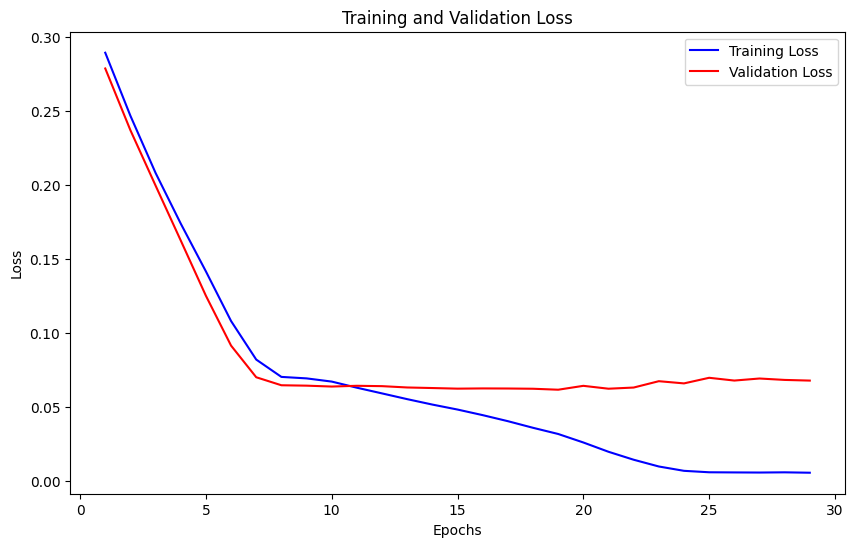

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', test_loss)

# Extract history for plotting loss over epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 1s 5ms/step


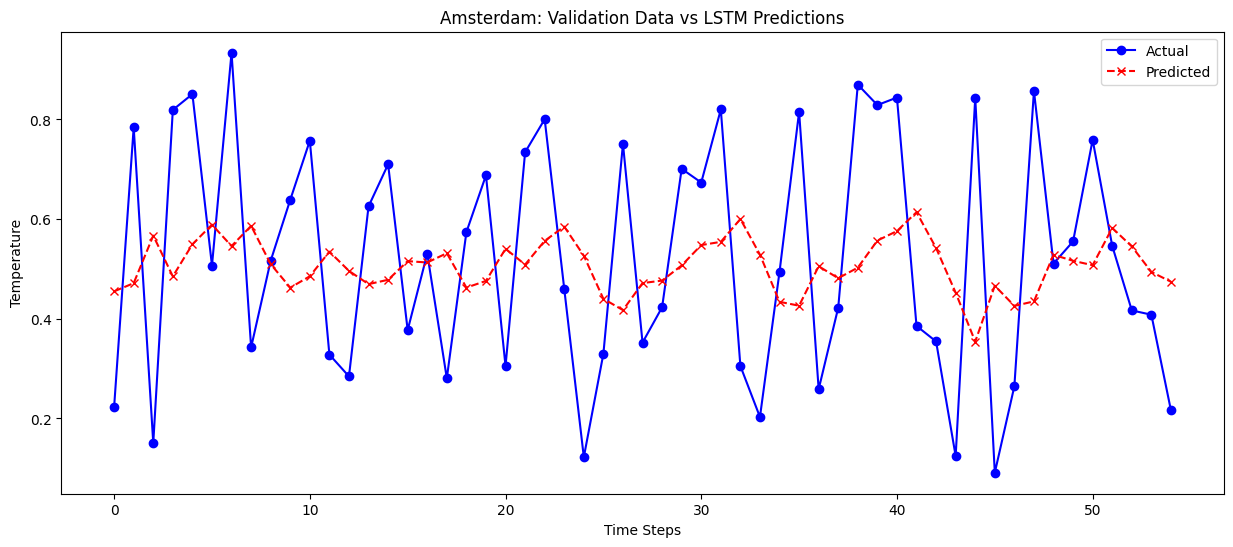

In [ ]:
# Make predictions on the validation data
y_val_pred = model.predict(X_val)

# Reshape y_val if necessary to ensure it matches the predictions shape
y_val = y_val.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_val, label='Actual', color='blue', marker='o')
plt.plot(y_val_pred.flatten(), label='Predicted', color='red', linestyle='--', marker='x')
plt.title(f"{city}: Validation Data vs LSTM Predictions")
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Amsterdam 5 Months

## Monthly Preprocess

In [ ]:
index = 5
cities = data['City'].unique().tolist()
cities.sort()
city = cities[index]
city_data = data[data['City'] == city].reset_index()
print("We are selecting \"" + city + "\" city for training with \"" + str(len(city_data)) + "\" data points.")

We are selecting "Amsterdam" city for training with "9236" data points.


In [ ]:
# Convert date information to a datetime object and set it as the index
city_data['Date'] = pd.to_datetime(city_data[['Year', 'Month', 'Day']])
city_data.set_index('Date', inplace=True)
city_data.sort_index(inplace=True)

# Select only the AvgTemperature column for simplicity, or multiple columns if needed
time_series = city_data['AvgTemperature'].resample('M').mean()

In [ ]:
# Calculate indices for 70% train, 20% validation, 10% test splits
train_size = int(len(time_series) * 0.7)
remaining = len(time_series) - train_size
validation_size = int(remaining * 0.67)  # Approximately 20% of the total
test_size = remaining - validation_size  # Approximately 10% of the total

# Generate train, validation, and test sets
train_data = time_series.iloc[:train_size]
remaining_data = time_series.iloc[train_size:]

# Randomly sample validation and test sets from the remaining data
validation_data = remaining_data.sample(n=validation_size)
test_data = remaining_data.drop(validation_data.index)  # Drop validation data points from remaining to form test set

In [ ]:
# Create a scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform all sets
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
validation_scaled = scaler.transform(validation_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

In [ ]:
def create_sequences(data, sequence_length=30):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        xs.append(data[i:(i + sequence_length)])
        ys.append(data[i + sequence_length])
    return np.array(xs), np.array(ys)

# Example usage
sequence_length = 5  # Using 6 Months of data to predict the next day
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val, y_val = create_sequences(validation_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

In [ ]:
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

In [ ]:
# Define the optimizer with a specific learning rate
learning_rate = 0.001  # Example learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=RootMeanSquaredError())

# Setup early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                    callbacks=[early_stopping], batch_size=32, verbose=1)

Epoch 1/50
7/7 [==============================] - 3s 112ms/step - loss: 0.3744 - root_mean_squared_error: 0.6119 - val_loss: 0.3365 - val_root_mean_squared_error: 0.5801
Epoch 2/50
7/7 [==============================] - 0s 15ms/step - loss: 0.3321 - root_mean_squared_error: 0.5762 - val_loss: 0.2991 - val_root_mean_squared_error: 0.5469
Epoch 3/50
7/7 [==============================] - 0s 16ms/step - loss: 0.2958 - root_mean_squared_error: 0.5439 - val_loss: 0.2640 - val_root_mean_squared_error: 0.5138
Epoch 4/50
7/7 [==============================] - 0s 31ms/step - loss: 0.2612 - root_mean_squared_error: 0.5110 - val_loss: 0.2309 - val_root_mean_squared_error: 0.4805
Epoch 5/50
7/7 [==============================] - 0s 39ms/step - loss: 0.2280 - root_mean_squared_error: 0.4774 - val_loss: 0.1986 - val_root_mean_squared_error: 0.4457
Epoch 6/50
7/7 [==============================] - 0s 19ms/step - loss: 0.1955 - root_mean_squared_error: 0.4421 - val_loss: 0.1657 - val_root_mean_squared

## Results Months

1/1 [==============================] - 0s 34ms/step - loss: 0.0533 - root_mean_squared_error: 0.2308
Test Loss: [0.05326513200998306, 0.23079240322113037]


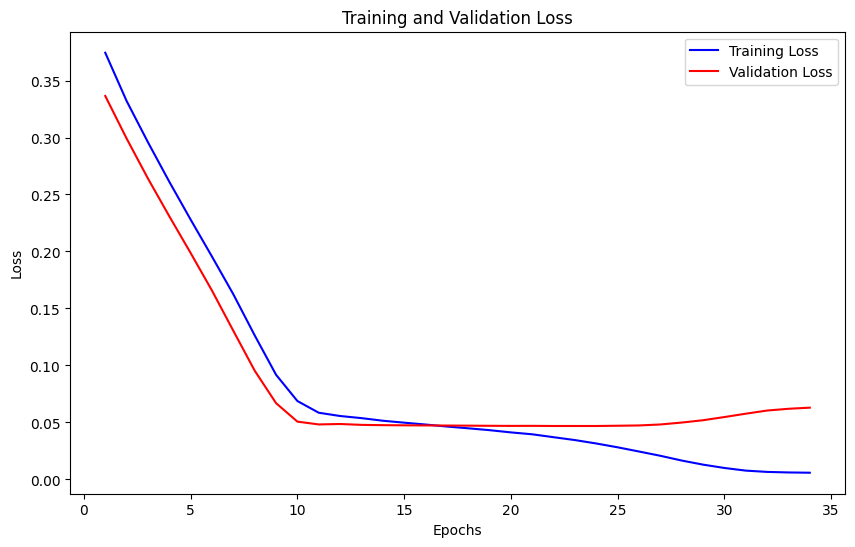

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', test_loss)

# Extract history for plotting loss over epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 5ms/step


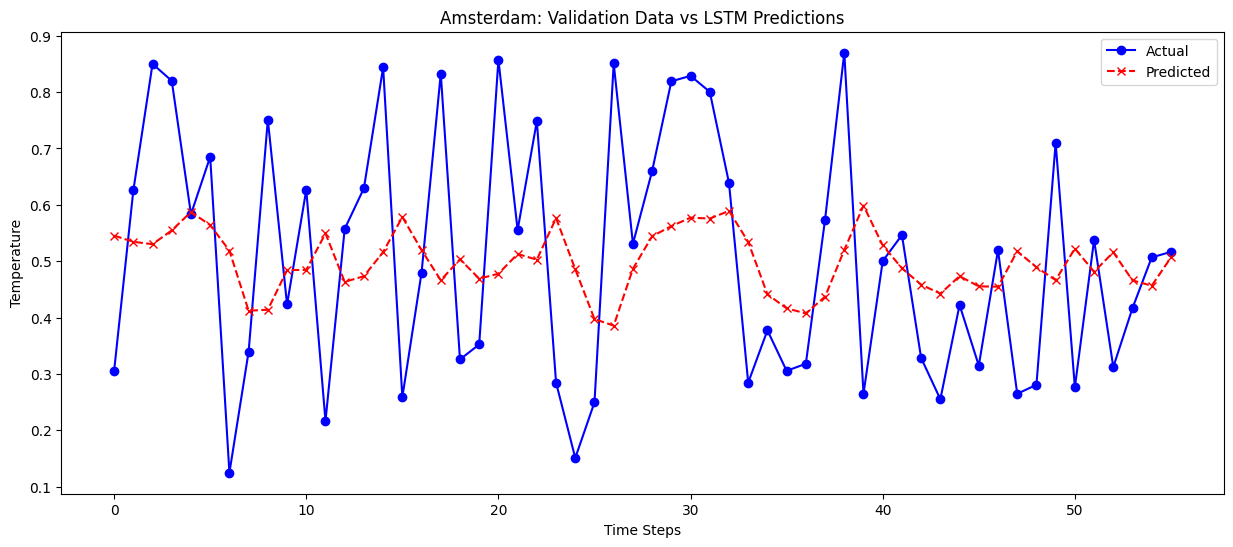

In [ ]:
# Make predictions on the validation data
y_val_pred = model.predict(X_val)

# Reshape y_val if necessary to ensure it matches the predictions shape
y_val = y_val.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_val, label='Actual', color='blue', marker='o')
plt.plot(y_val_pred.flatten(), label='Predicted', color='red', linestyle='--', marker='x')
plt.title(f"{city}: Validation Data vs LSTM Predictions")
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Moscow 5 Months

## Monthly Preprocess

In [ ]:
index = 76
cities = data['City'].unique().tolist()
cities.sort()
city = cities[index]
city_data = data[data['City'] == city].reset_index()
print("We are selecting \"" + city + "\" city for training with \"" + str(len(city_data)) + "\" data points.")

We are selecting "Moscow" city for training with "9235" data points.


In [ ]:
# Convert date information to a datetime object and set it as the index
city_data['Date'] = pd.to_datetime(city_data[['Year', 'Month', 'Day']])
city_data.set_index('Date', inplace=True)
city_data.sort_index(inplace=True)

# Select only the AvgTemperature column for simplicity, or multiple columns if needed
time_series = city_data['AvgTemperature'].resample('M').mean()

In [ ]:
# Calculate indices for 70% train, 20% validation, 10% test splits
train_size = int(len(time_series) * 0.7)
remaining = len(time_series) - train_size
validation_size = int(remaining * 0.67)  # Approximately 20% of the total
test_size = remaining - validation_size  # Approximately 10% of the total

# Generate train, validation, and test sets
train_data = time_series.iloc[:train_size]
remaining_data = time_series.iloc[train_size:]

# Randomly sample validation and test sets from the remaining data
validation_data = remaining_data.sample(n=validation_size)
test_data = remaining_data.drop(validation_data.index)  # Drop validation data points from remaining to form test set

In [ ]:
# Create a scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform all sets
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
validation_scaled = scaler.transform(validation_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

In [ ]:
def create_sequences(data, sequence_length=30):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        xs.append(data[i:(i + sequence_length)])
        ys.append(data[i + sequence_length])
    return np.array(xs), np.array(ys)

# Example usage
sequence_length = 5  # Using 6 Months of data to predict the next day
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val, y_val = create_sequences(validation_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

In [ ]:
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

In [ ]:
# Define the optimizer with a specific learning rate
learning_rate = 0.001  # Example learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=RootMeanSquaredError())

# Setup early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                    callbacks=[early_stopping], batch_size=32, verbose=1)

Epoch 1/50
7/7 [==============================] - 2s 48ms/step - loss: 0.2483 - root_mean_squared_error: 0.4983 - val_loss: 0.2130 - val_root_mean_squared_error: 0.4615
Epoch 2/50
7/7 [==============================] - 0s 9ms/step - loss: 0.2213 - root_mean_squared_error: 0.4704 - val_loss: 0.1859 - val_root_mean_squared_error: 0.4312
Epoch 3/50
7/7 [==============================] - 0s 13ms/step - loss: 0.1921 - root_mean_squared_error: 0.4383 - val_loss: 0.1580 - val_root_mean_squared_error: 0.3975
Epoch 4/50
7/7 [==============================] - 0s 11ms/step - loss: 0.1625 - root_mean_squared_error: 0.4031 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3591
Epoch 5/50
7/7 [==============================] - 0s 12ms/step - loss: 0.1323 - root_mean_squared_error: 0.3637 - val_loss: 0.0988 - val_root_mean_squared_error: 0.3144
Epoch 6/50
7/7 [==============================] - 0s 11ms/step - loss: 0.1026 - root_mean_squared_error: 0.3203 - val_loss: 0.0714 - val_root_mean_squared_e

## Results Months

1/1 [==============================] - 0s 26ms/step - loss: 0.0503 - root_mean_squared_error: 0.2242
Test Loss: [0.05027945712208748, 0.2242308109998703]


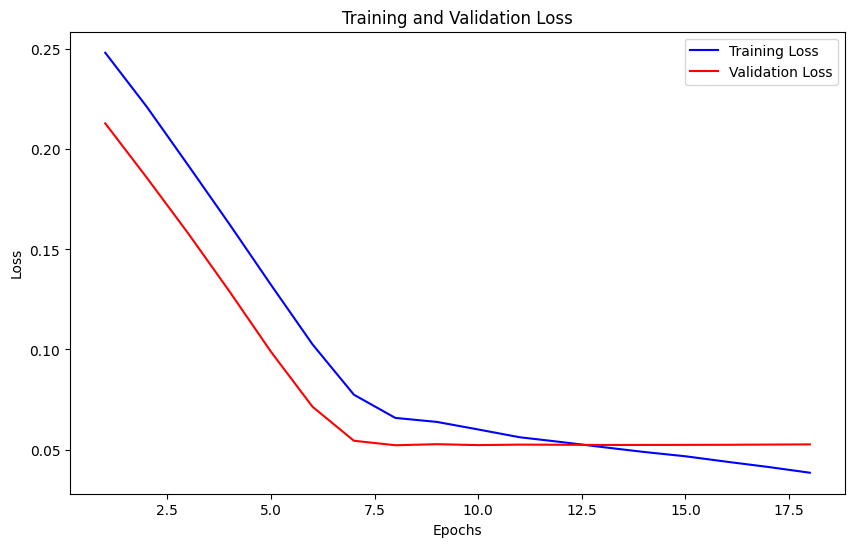

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', test_loss)

# Extract history for plotting loss over epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 7ms/step


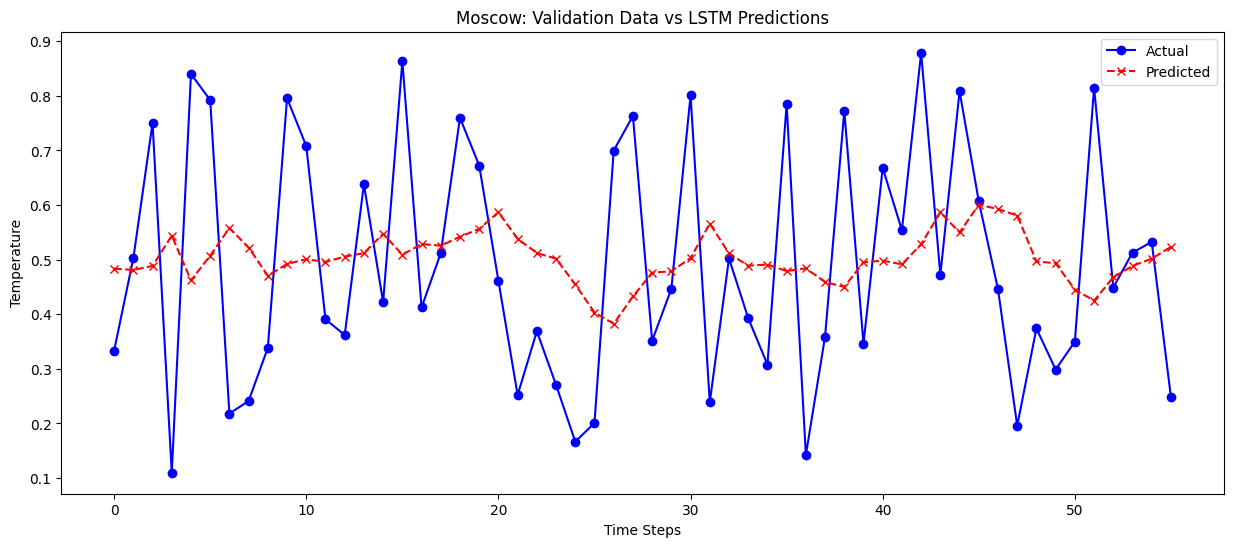

In [ ]:
# Make predictions on the validation data
y_val_pred = model.predict(X_val)

# Reshape y_val if necessary to ensure it matches the predictions shape
y_val = y_val.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_val, label='Actual', color='blue', marker='o')
plt.plot(y_val_pred.flatten(), label='Predicted', color='red', linestyle='--', marker='x')
plt.title(f"{city}: Validation Data vs LSTM Predictions")
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()